# 1. Install Dependencies and Setup

In [1]:
import tensorflow as tf
import os

C:\Users\sacha\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

# 2. Remove dodgy images

In [3]:
import cv2
import imghdr
from matplotlib import pyplot as plt

C:\Users\sacha\AppData\Local\Temp\ipykernel_35600\3427753027.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [4]:
data_dir =r"C:\Users\sacha\Downloads\data_image"

In [5]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [6]:
img= cv2.imread(os.path.join(data_dir, 'happy', 'traitshappypeople.jpg'))

In [7]:
img.shape

(820, 1920, 3)

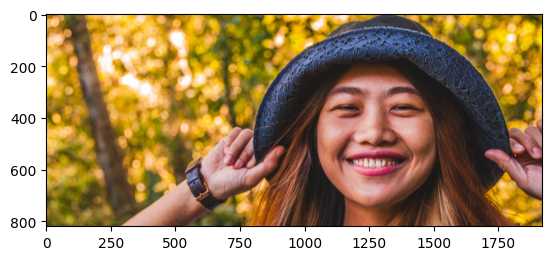

In [8]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [9]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path
        

# 3. Loading the Data 

In [10]:
import numpy as np
from matplotlib import pyplot as plt

In [11]:
data = tf.keras.utils.image_dataset_from_directory(r"C:\Users\sacha\Downloads\data_image")

Found 160 files belonging to 2 classes.


In [12]:
data_iterator = data.as_numpy_iterator()

In [13]:
batch = data_iterator.next()
len(batch)

2

In [14]:
#Images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [15]:
# here are the labels (1 represents sad people, 0 represents happy people)
batch[1]

array([0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 0])

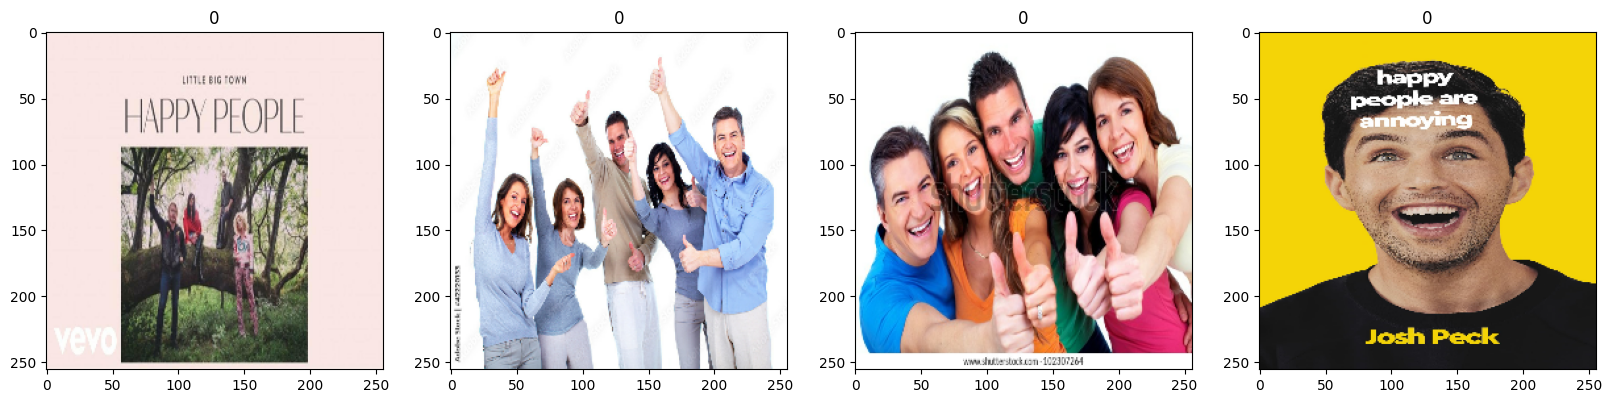

In [16]:
fig, ax = plt.subplots (ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Preprocess the data 

In [17]:
# scale the data

data = data.map(lambda x, y: (x/255 , y))

###### our data is now between 0 and 1


In [18]:
print(data.as_numpy_iterator().next()[0].max())
print(data.as_numpy_iterator().next()[0].min())

1.0
0.0


# 5 Split the Data

In [19]:
len (data)

5

In [20]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2)
test_size = len(data) - train_size - val_size

In [21]:
train_size+val_size+test_size

5

In [22]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [23]:
len(train)

3

# 4. Deep Learning


## 4.1 Build Deep Learning Model

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten


In [25]:
model = Sequential()

In [26]:
# 16 filters, a filter is of size 3*3, the stride is 1
model.add(Conv2D(16, (3,3),1, activation= 'relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3),1, activation= 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3),1, activation= 'relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation= 'relu'))
model.add(Dense(1, activation= 'sigmoid'))


C:\Users\sacha\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

## 4.2 Build Deep Learning Model


In [29]:
logdir= r"C:\Users\sacha\OneDrive\Documents\logs"

In [30]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir) 

In [31]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.5547 - loss: 1.0961 - val_accuracy: 0.3750 - val_loss: 2.0071
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.4896 - loss: 1.5211 - val_accuracy: 0.6875 - val_loss: 0.6047
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.6419 - loss: 0.6468 - val_accuracy: 0.6562 - val_loss: 0.5197
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.5638 - loss: 0.5758 - val_accuracy: 0.5938 - val_loss: 0.5386
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.5977 - loss: 0.5583 - val_accuracy: 0.7812 - val_loss: 0.5378
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.7539 - loss: 0.5515 - val_accuracy: 0.6250 - val_loss: 0.5992
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8281 - loss: 0.4928 - val_accuracy: 0.7188 - val_loss: 0.6068
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8477 - loss: 0.4738 - val_accuracy: 0.8750 - val_loss: 0.3742
Epoch 9/20
3/3 

In [32]:
hist.history

{'accuracy': [0.5625,
  0.4791666567325592,
  0.5729166865348816,
  0.5416666865348816,
  0.625,
  0.78125,
  0.8125,
  0.84375,
  0.75,
  0.8333333134651184,
  0.8645833134651184,
  0.8854166865348816,
  0.90625,
  0.9270833134651184,
  0.875,
  0.9270833134651184,
  0.9583333134651184,
  0.9375,
  0.9583333134651184,
  0.9895833134651184],
 'loss': [1.2224822044372559,
  1.3612712621688843,
  0.7055395245552063,
  0.579850435256958,
  0.5616284608840942,
  0.5441814064979553,
  0.4902167022228241,
  0.46287664771080017,
  0.4830816686153412,
  0.4135480225086212,
  0.362803190946579,
  0.3172549903392792,
  0.28347960114479065,
  0.23082007467746735,
  0.2642079293727875,
  0.21601541340351105,
  0.17564278841018677,
  0.17901432514190674,
  0.14379297196865082,
  0.0992174968123436],
 'val_accuracy': [0.375,
  0.6875,
  0.65625,
  0.59375,
  0.78125,
  0.625,
  0.71875,
  0.875,
  0.84375,
  0.8125,
  0.90625,
  0.84375,
  0.96875,
  0.8125,
  1.0,
  0.96875,
  0.96875,
  1.0,
  0.9

## 4.3 Plot Performance

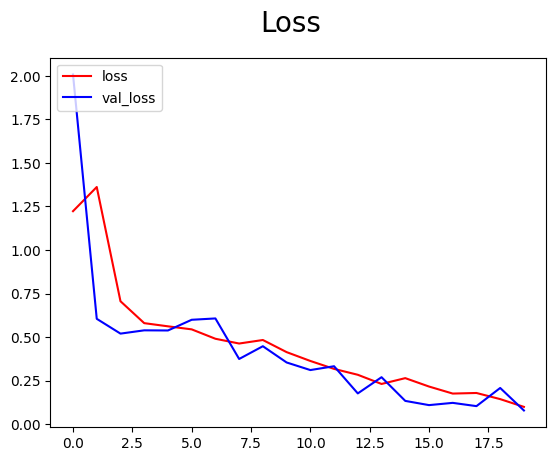

In [33]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='red', label= 'loss')
plt.plot(hist.history['val_loss'], color = 'blue', label= 'val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

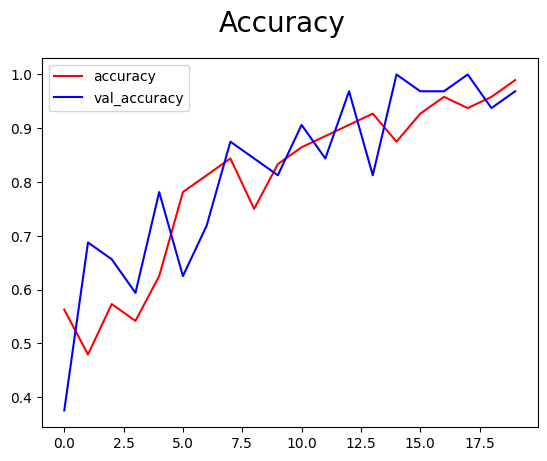

In [34]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='red', label= 'accuracy')
plt.plot(hist.history['val_accuracy'], color = 'blue', label= 'val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

# 4.Evaluate Performance


## 4.1 Evaluate



In [35]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [36]:
pre= Precision()
re = Recall()
acc = BinaryAccuracy()

In [37]:
for batch in test.as_numpy_iterator():
    X,y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


In [38]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 1.0, Recall:1.0, Accuracy:1.0


## 4.2 Testing on other data


In [39]:
import cv2

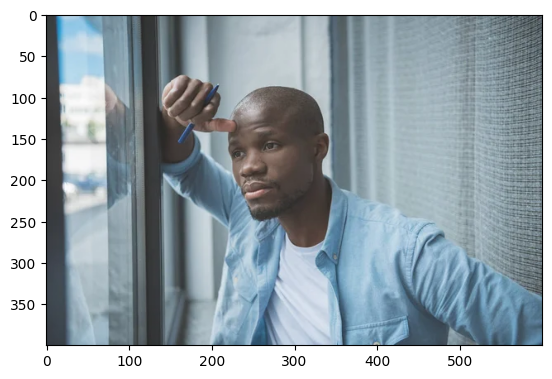

In [40]:
img = cv2.imread(r"C:\Users\sacha\Downloads\test_sad.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

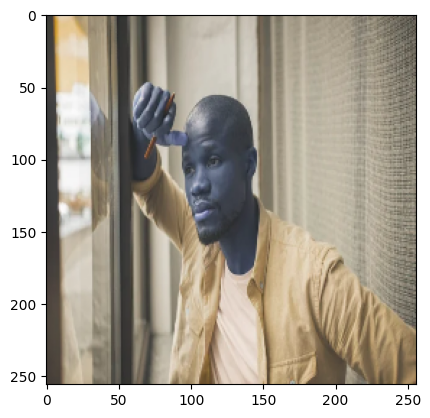

In [41]:
resize = tf.image.resize(img,(256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

Our neural network is not expecting one single image hence we have to encapsulate it using expand_dims here is the example:

In [42]:
resize.shape

TensorShape([256, 256, 3])

In [43]:
np.expand_dims(resize,0).shape

(1, 256, 256, 3)

In [44]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


In [45]:
yhat

array([[0.5894465]], dtype=float32)

In [46]:
if yhat > 0.5:
    print(f'Predicted Class is Sad')
else:
    print(f'Predicted Class is Happy')

Predicted Class is Sad
